# ***Homework02***

### ***Email Spam Classifier***

In [1]:
### Library import 
# Data processing
import os
import email
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# Import Models
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

# Drive Mount
from google.colab import drive
drive.mount("/content/drive")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive


In [2]:
### Import Data Sets
# Define folder path
spam_base_directory = "/content/drive/MyDrive/DS5220_Supervised Machine Learning/Assignments/HW02/spam"
ham_base_directory = "/content/drive/MyDrive/DS5220_Supervised Machine Learning/Assignments/HW02/easy_ham"
spam_emails = os.listdir(spam_base_directory)
ham_emails = os.listdir(ham_base_directory)
# Read the emails
def load_email(filename, directory):
    with open(os.path.join(directory, filename), "rb") as f:
      return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
spam_emails = [load_email(filename, spam_base_directory) for filename in spam_emails]
ham_emails = [load_email(filename, ham_base_directory) for filename in ham_emails]

print("# of SPAM emails", len(spam_emails))
print("# of HAM emails", len(ham_emails))

# of SPAM emails 501
# of HAM emails 2501


In [3]:
spam_emails[5].get_payload()

'Hi,\n\nI\'m a college dropout.  I work about two hours a day.  \nI\'m ambitious, but extremely lazy, and I make over \n$250,000 a year.  Are you curious yet?\n\nIn a minute I\'m going to tell you my secret,\nit\'s the dirty little secret of the Internet ...\n\nYou\'ve probably heard stories about people making\nwhopping huge money online, but you thought they \nwere the big corporate execs, famous programmers, or\nboy-geniuses.\n\nWell, grasshopper, think again ...\n\nIt\'s people like you and me that are making the real\nmoney.  Yep, people like YOU AND ME!\n\nEver since the "dot com bubble" burst in 1999, small-time\nentrepreneurs are getting richer while the Fortune 500 \ncompanies look for bankruptcy lawyers.\n\nToday small business owners and ordinary folks \nlike you and me can use the web to achieve complete \nfinancial freedom with NO INVESTMENT and very little \nwork.  How?  By learning the most profitable marketing \ntechnique ever created - it\'s called BULK EMAIL.\n\nIf yo

In [23]:
### Data precessing
def process_email(emails, label, data_dictionary, default_topic=None):
    """
    Convert Email Datas to DataFrame
    Split data into three(Subject, Content, Label)
    """
    for mail in emails:
        payload = mail.get_payload()
        """If payload is instance of list proceed process_email"""
        if isinstance(payload, list): 
            process_email(payload, label, data_dictionary, default_topic=mail["Subject"])
        else:
            """Read Data in two occasions 1. HTML 2. Plain"""
            if "Content-Type" in mail.keys():
                if "html" in mail["Content-Type"].lower():
                  """Parsing email text by BeautifulSoup"""
                  try: 
                        soup = BeautifulSoup(mail.get_content())
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = soup.body.text
                        data_dictionary["subject"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                  except:
                        pass
                elif "plain" in mail["Content-Type"].lower():
                  """Parsing email text"""
                  try: 
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = mail.get_content()
                        data_dictionary["subject"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                  except:
                        pass
                else:
                    pass

# define disctionary stucture
emails_dictionary = {"subject": [], "content": [], "label": []}

# Get Email Contents
process_email(spam_emails, 1, emails_dictionary)
process_email(ham_emails, 0, emails_dictionary)

# Convert Dictionaryt o DataFrame
emails_df = pd.DataFrame(emails_dictionary)
emails_df.head()

,subject,content,label
0,How would you like to create your own DVD libr...,Here's the hottest thing in DVDs. Now you can ...,1
1,don't proscrastinate...it's only $14.95 per year,IMPORTANT INFORMATION:\r\n\r\nThe new domain n...,1
2,Pics for you,GET FREE ACCESS TO XXX PORN!INSTANT ACCESS... ...,1
3,Too Busy Earning A Living To Make Any Money,Do You Want To Teach and Grow Rich?\n\n\n\n\n\...,1
4,Re: Fw: User Name & Password to Membership To ...,##############################################...,1


In [24]:
### Preprocessing 
# Text Cleaning
def Preprocessing_clean(text): 
  """
  Before vectorize the text data, clean the data
  """
  text = text.lower()
  text = re.sub(r"don't", "do not", text)
  text = re.sub(r"isn't", "is not", text)
  text = re.sub(r"aren't", "are not", text)
  text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
  text = re.sub('[^A-Za-z]+', ' ', text)
  text = re.sub(r"(\#\w+)", "", text)
  text = re.sub(r"(\@\w+)", "", text)
  text = re.sub(r"\S*https?:\S*", "", text)
  text = re.sub("http\S+","",text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(' s ',' ',text)
  text = re.sub(r"rt ", "", text)
  text = text.lstrip().rstrip()
  return text

# Proceed Preprocessing_clean function
"""Apply to text data"""
Cleaned_content = [] 
for i in emails_df["content"]:
  try:
    Cleaned_content.append(Preprocessing_clean(i))
  except:
    Cleaned_content.append("")

In [7]:
### Stop words
def Stop_words(Stop_list):
  # Remove Stop words 
  """If words are smaller than number of 3, subtract the words"""
  Stopwords_content = Stop_list.split()
  Keepwords_content = []
  for i in Stopwords_content:
    if len(i) > 3:
      Keepwords_content.append(i)

  """Sorted part of verb and nouns"""
  Lem_content = []
  for i in Keepwords_content:
    wd = wordnet_lemmatizer.lemmatize(i, pos="v")
    Lem_content.append(wd)
  Lems_content = []
  for j in Lem_content:
    wd = wordnet_lemmatizer.lemmatize(j, pos="n") 
    Lems_content.append(wd)
  
  Stop_list = [" ".join(Lems_content)]
  return Stop_list

# Applying Stopwords
stp = {}
stop_word = []
for i in range(len(Cleaned_content)):
  stp[str(i)] = Cleaned_content[i] 
  stp[str(i)] = Stop_words(stp[str(i)])
  stop_word.extend(stp[str(i)])

stop_word[0]

'here hottest thing dvd make personal backup copy right onto software easily take through step make copy your dvd include free copy playstation music software step step interactive instruction software tool include burner require free live technical suppoday risk free trial available free movie your choice limit time offer have software need copy your movie this email be screen filter house system compliance with state law wish from this mail well list thousand other email provider please visit zkzm blan zxad bmnt tico rikg'

In [8]:
### TF-IDF (Vectorizing)
from sklearn.feature_extraction.text import TfidfVectorizer

"""Vecotrize data"""
tfidfconverter = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
content_idf = tfidfconverter.fit_transform(stop_word).toarray()
content_idf = pd.DataFrame(content_idf, columns=tfidfconverter.get_feature_names_out())
content_idf[:10]

,ability,able,absolutely,accept,access,accord,account,achieve,across,action,...,would,write,wrong,xent,xine,yahoo,year,yesterday,york,young
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.000000,0.0,0.000000,0.000000,0.060855,0.0,0.00000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.000000,0.000000,0.505193,0.0,0.00000,0.00000,0.0,0.0,...,0.324769,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,0.083806,0.000000,0.108185,0.0,0.03861,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.026652,0.0,0.000000,0.0
5,0.000000,0.0,0.023618,0.000000,0.000000,0.0,0.00000,0.02902,0.0,0.0,...,0.026134,0.000000,0.000000,0.0,0.0,0.0,0.075111,0.0,0.024532,0.0
6,0.016036,0.0,0.016084,0.015132,0.000000,0.0,0.00000,0.00000,0.0,0.0,...,0.035593,0.007259,0.014184,0.0,0.0,0.0,0.010230,0.0,0.016706,0.0
7,0.000000,0.0,0.000000,0.192317,0.000000,0.0,0.00000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
8,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
9,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,...,0.266207,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [25]:
### X, y
X = pd.DataFrame(content_idf)
y = emails_df["label"]

### Split Data
X_train, X_test, y_train, y_test = train_test_split(content_idf, y, test_size=0.2, random_state=22)
print("Len Train: ", len(X_train))
print("Len Test: ", len(X_test))

Len Train:  2109
Len Test:  528


In [11]:
### Model Fitting
# Random Forest
import sklearn.ensemble
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=8, random_state=22) 
rnd_clf.fit(X_train, y_train) 

y_pred_rf = rnd_clf.predict(X_test) 

# Logistic Regression 
from sklearn.linear_model import LogisticRegression 
log_clf = LogisticRegression(solver="liblinear", random_state=22)
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test) 

# Naive Bayes
from sklearn.naive_bayes import GaussianNB 
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train) 

y_pred_nb = nb_clf.predict(X_test)

Confusion Matrix Tree : 
 [[421   0]
 [ 31  76]] 

The precision for Tree is  1.0
The recall for Tree is  0.7102803738317757 



<AxesSubplot:>

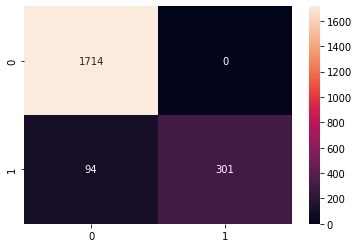

In [12]:
### Confusion Matrix
# Random Forest
print("Confusion Matrix Tree : \n" , confusion_matrix(y_test, y_pred_rf),"\n")
print("The precision for Tree is ", precision_score(y_test, y_pred_rf)) 
print("The recall for Tree is ",recall_score(y_test, y_pred_rf),"\n")  

# Confusion Matrix Graph
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(y_train, rnd_clf.predict(X_train))
sns.heatmap(cm, annot=True, fmt="d")

Confusion Matrix Tree : 
 [[420   1]
 [ 17  90]] 

The precision for Tree is  0.989010989010989
The recall for Tree is  0.8411214953271028 



<AxesSubplot:>

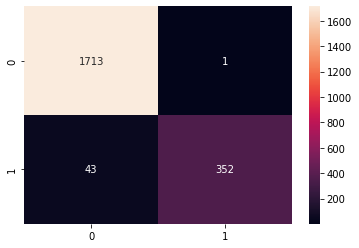

In [13]:
# Logistic Regression
print("Confusion Matrix Tree : \n" , confusion_matrix(y_test, y_pred_log),"\n")
print("The precision for Tree is ", precision_score(y_test, y_pred_log)) 
print("The recall for Tree is ",recall_score(y_test, y_pred_log),"\n")  

# Confusion Matrix Graph
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(y_train, log_clf.predict(X_train))
sns.heatmap(cm, annot=True, fmt="d")

Confusion Matrix Tree : 
 [[394  27]
 [ 11  96]] 

The precision for Tree is  0.7804878048780488
The recall for Tree is  0.897196261682243 



<AxesSubplot:>

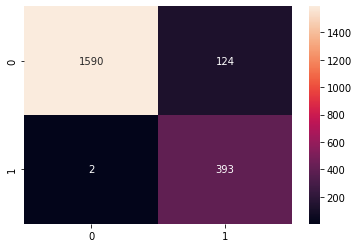

In [14]:
# Naive Bayes Regression
print("Confusion Matrix Tree : \n" , confusion_matrix(y_test, y_pred_nb),"\n")
print("The precision for Tree is ", precision_score(y_test, y_pred_nb)) 
print("The recall for Tree is ",recall_score(y_test, y_pred_nb),"\n")  

# Confusion Matrix Graph
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(y_train, nb_clf.predict(X_train))
sns.heatmap(cm, annot=True, fmt="d")

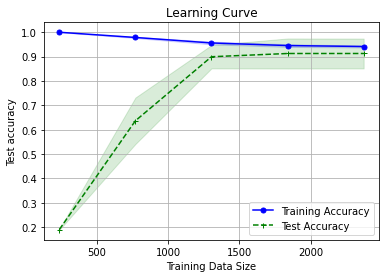

In [15]:
### Plot Learning Curve 
"""
x: Train data size y: Test accuracy
Plot the Learning curve, according to number of Train data

Problem08
Until getting reach to a number of train data 1300, the test accuracy keeps increasing
Unitl a number of train data reached 1350, the accuracy remains the approximate number 
"""
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(estimator=nb_clf, X=X, y=y, 
                                                  cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Test Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Test accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [26]:
### Feature Importance
y = pd.DataFrame(y)
df = pd.concat([content_idf, y], axis=1)

import math
def Feature_importance(column, df):
    """
    Get Spam & Ham Conditional probabilities
    Because of the log, if conditional probabilities are 0, remove the value 
    """
    col_name = column
    cond_ham_prob = len(df.loc[(df[column]>0) & (df["label"]==0)])
    cond_spam_prob = len(df.loc[(df[column]>0) & (df["label"]==1)])
    cond = cond_spam_prob / cond_ham_prob
    if cond != 0:
      return math.log(cond)

# Column names 
Column_names = []
for i in range(1000):
  column = content_idf.columns[i]
  Column_names.append(column)

# Feature importance
"""Organize feature importance data with ascending order"""
arr_name = []
arr_odds = []
for i in range(1000):
  arr_name.append(Column_names[i]) 
  arr_odds.append(Feature_importance(Column_names[i], df)) 
name = pd.DataFrame({"Name":arr_name})
odds = pd.DataFrame({"Log_odds":arr_odds}) 
Log_odds = pd.concat([name, odds], axis=1)
Log_odds = Log_odds.sort_values("Log_odds", ascending=True)
Log_odds[:10]

,Name,Log_odds
441,install,-4.624973
771,root,-4.510860
367,geek,-4.418841
58,article,-4.382027
566,monday,-4.382027
232,device,-4.219508
783,script,-4.189655
654,platform,-4.127134
846,spec,-4.007333
852,sponsor,-4.003690
